In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

In [3]:
# test_df = pd.read_excel('/content/drive/MyDrive/UIT-VSMEC/test_nor_811.xlsx')
# train_df = pd.read_excel('/content/drive/MyDrive/UIT-VSMEC/train_nor_811.xlsx')
# val_df = pd.read_excel('/content/drive/MyDrive/UIT-VSMEC/valid_nor_811.xlsx')

In [2]:
test_df = pd.read_excel('/kaggle/input/uit-vsmec/test_nor_811.xlsx')
train_df = pd.read_excel('/kaggle/input/uit-vsmec/train_nor_811.xlsx')
val_df = pd.read_excel('/kaggle/input/uit-vsmec/valid_nor_811.xlsx')

In [3]:
test_df

,Unnamed: 0,Emotion,Sentence
0,713,Sadness,người ta có bạn bè nhìn vui thật
1,1827,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật
2,1166,Disgust,kinh vãi 😡
3,228,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4,1942,Anger,bố không thích nộp đấy mày thích ý kiến không
...,...,...,...
688,432,Sadness,lúc thì cuốc đất è cổ ra không có giun mà câu ...
689,178,Enjoyment,các bác dẫn crush qua cây sữa nay mà hứng nước...
690,1863,Surprise,vợ chồng rồi mà trong sáng như này chỉ có tron...
691,476,Other,bep này vào binh dương dùng xuất


In [5]:
test_df.columns = ['index', 'Emotion', 'Sentence']
train_df.columns = ['index', 'Emotion', 'Sentence']
val_df.columns = ['index', 'Emotion', 'Sentence']

In [ ]:
train_df= train_df.drop(columns = ['index'])
test_df = test_df.drop(columns = ['index'])
val_df = val_df.drop(columns = ['index'])

In [8]:
val_df

,Emotion,Sentence
0,Other,"tính tao tao biết , chẳng có chuyện gì có thể ..."
1,Enjoyment,"lại là lào cai , tự hào quê mình quá :))"
2,Sadness,bị từ chối rồi
3,Enjoyment,tam đảo trời đẹp các mem à
4,Other,đọc bình luận của thằng đó không thiếu chữ nào 😂😂
...,...,...
681,Sadness,nhọc lòng :(((
682,Sadness,tao đã rất muốn làm bạn tốt anh em tri kỉ với ...
683,Disgust,cơm tấm ở ngoài cũng như này . 😡
684,Surprise,chất liệu đỉnh quá


<Axes: xlabel='Emotion', ylabel='count'>

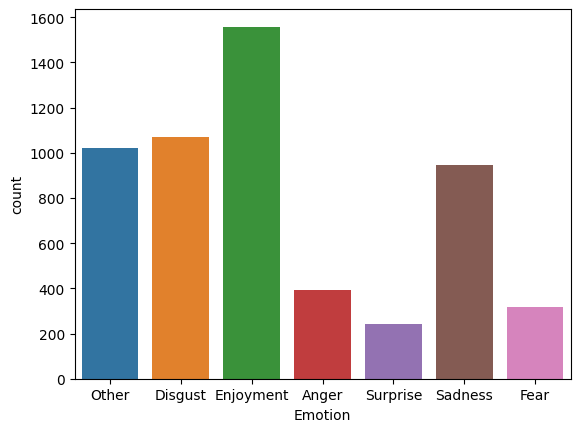

In [9]:
sns.countplot(x='Emotion', data=train_df)


In [20]:

# Tải pre-trained word embeddings
bert = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [11]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=50):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def labelencoder(self, text):
        if text == 'Enjoyment':
            return 0
        elif text == 'Disgust':
            return 1
        elif text == 'Sadness':
            return 2
        elif text == 'Anger':
            return 3
        elif text == 'Surprise':
            return 4
        elif text == 'Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])
        return text, label

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = bert
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [22]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased", use_fast=False)
train_dataset = SentimentDataset(train_df, tokenizer, max_len=100)
valid_dataset = SentimentDataset(val_df, tokenizer, max_len=100)
test_dataset = SentimentDataset(test_df, tokenizer, max_len=100)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 9.444444444444438, 'Token Count')

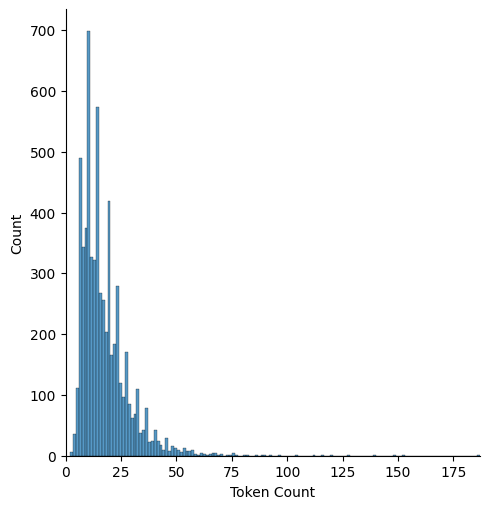

In [24]:
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SentimentClassifier(n_classes=7).to(device)



criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001)
EPOCHS = 20
lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )

In [26]:
from sklearn.metrics import f1_score
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    all_preds = []
    all_targets = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}, F1: {f1}')


def eval(data_loader):
    model.eval()
    losses = []
    all_preds = []
    all_targets = []
    correct = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f'Accuracy: {correct.double()/len(data_loader.dataset)} Loss: {np.mean(losses)}, F1={f1}')
    return correct.double()/len(data_loader.dataset)

In [28]:
import os
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"

Epoch 1/20
------------------------------
Train Accuracy: 0.29019466474405187 Loss: 1.7606875992369377, F1: 0.23084344440423063
Accuracy: 0.282798833819242 Loss: 1.9208898869427768, F1=0.23349108657878806
Epoch 2/20
------------------------------
Train Accuracy: 0.3455299206921413 Loss: 1.6518967233855149, F1: 0.28901763146888126
Accuracy: 0.3717201166180758 Loss: 1.6445689851587468, F1=0.29198739004119606
Epoch 3/20
------------------------------
Train Accuracy: 0.40753424657534243 Loss: 1.5156875245872585, F1: 0.362250189648943
Accuracy: 0.4329446064139942 Loss: 1.5394553379579023, F1=0.3605674698269898
Epoch 4/20
------------------------------
Train Accuracy: 0.46683489545782264 Loss: 1.3872177737882767, F1: 0.4257586954867244
Accuracy: 0.4314868804664723 Loss: 1.5083702694285999, F1=0.3693444874171371
Epoch 5/20
------------------------------
Train Accuracy: 0.5171232876712328 Loss: 1.2717786451865887, F1: 0.48122272709659236
Accuracy: 0.45918367346938777 Loss: 1.5640448982065374, 

<Axes: >

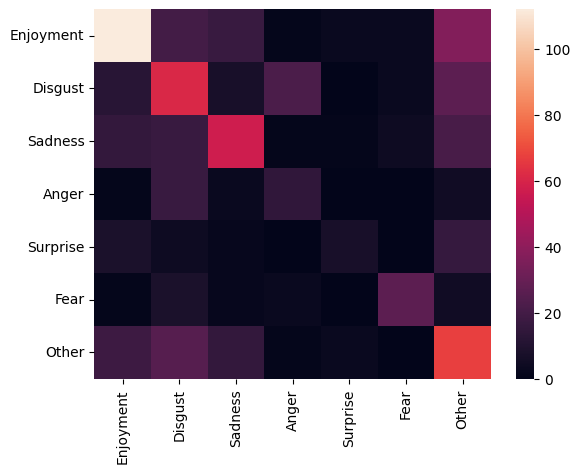

In [29]:
best_acc = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    train(model, criterion, optimizer, train_loader)
    val_acc = eval(valid_loader)

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'phobert_best.pth')
        best_acc = val_acc

print('testing')
model.eval()
real_values = []
predicts = []

with torch.no_grad():
    for data in test_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, pred = torch.max(outputs, dim=1)
        real_values.extend(targets.cpu().numpy())
        predicts.extend(pred.cpu().numpy())

test_acc = np.sum(np.array(real_values) == np.array(predicts)) / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc} ')

# Heatmap
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels=class_names, yticklabels=class_names)



In [30]:
import torch.nn.functional as F

def infer(text, tokenizer, max_len=100):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)
    probs = F.softmax(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')
    for i, prob in enumerate(probs[0]):
        print(f'Sentiment prediction: {class_names[i]} {prob.item()*100:.2f}%')

In [42]:
infer("đường của nhà cụ hay sao mà cụ cấm người ta đỗ..", tokenizer)

Text: đường của nhà cụ hay sao mà cụ cấm người ta đỗ..
Sentiment: Disgust
Sentiment prediction: Enjoyment 0.06%
Sentiment prediction: Disgust 98.65%
Sentiment prediction: Sadness 0.06%
Sentiment prediction: Anger 0.35%
Sentiment prediction: Surprise 0.02%
Sentiment prediction: Fear 0.60%
Sentiment prediction: Other 0.27%


In [21]:
from huggingface_hub import create_repo
from transformers import AutoConfig

# 1. Lưu tokenizer
tokenizer.save_pretrained("phobert_sentiment")

# 2. Lấy config của model
config = AutoConfig.from_pretrained("vinai/phobert-base")

# 3. Lưu model với config
model.config = config
torch.save(model.state_dict(), "phobert_sentiment/pytorch_model.bin")

# 4. Tạo repo trên Hugging Face (nếu chưa tồn tại)
create_repo(repo_id="lecyanh/phobert_sentiment", exist_ok=True)

# 5. Upload model
api.upload_folder(
    folder_path="SentimentPrediction",
    repo_id="leycanh/phobert_sentiment",
    repo_type="model",
)

ValueError: Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.